In [1]:
from fastai.collab import *
from fastai.tabular import *

## Movielens 100k

In [12]:
path=Path('data')
path.ls()

[PosixPath('data/ml-100k.zip')]

In [14]:
#Unzip file downloaded from kaggle website
import zipfile
with zipfile.ZipFile(str(path)+"/ml-100k.zip" , 'r') as zip_ref:
    zip_ref.extractall(path)

In [15]:
path.ls()

[PosixPath('data/ml-100k.zip'), PosixPath('data/ml-100k')]

In [16]:
user,item,title = 'userId','movieId','title'

In [19]:
ratings = pd.read_csv(path/'ml-100k/u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [20]:
movies = pd.read_csv(path/'ml-100k/u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [21]:
len(ratings)

100000

In [22]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [23]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [24]:
data.show_batch()

userId,title,target
455,Toy Story (1995),4.0
337,Star Wars (1977),5.0
250,Winnie the Pooh and the Blustery Day (1968),5.0
846,Jason's Lyric (1994),2.0
655,In the Line of Fire (1993),3.0


In [25]:
y_range = [0,5.5]

In [26]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


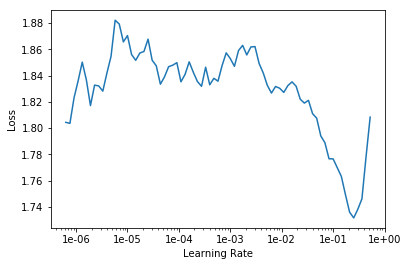

In [27]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [28]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,0.899160,0.922859,00:06
1,0.830718,0.847713,00:06
2,0.714667,0.831366,00:06


In [29]:
learn.save('dotprod')

## Interpretation

### Setup

In [30]:
learn.load('dotprod');

In [31]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [32]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie weights

In [33]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [34]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [35]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [36]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.2684), 'D3: The Mighty Ducks (1996)'),
 (tensor(1.2500), 'Flipper (1996)'),
 (tensor(1.2416), 'Children of the Corn: The Gathering (1996)'),
 (tensor(1.2141), 'Leave It to Beaver (1997)'),
 (tensor(1.1859), 'Bio-Dome (1996)'),
 (tensor(1.1658), 'Stupids, The (1996)'),
 (tensor(1.1619), 'Jungle2Jungle (1997)'),
 (tensor(1.1614), 'Speed 2: Cruise Control (1997)'),
 (tensor(1.1118), 'Free Willy 3: The Rescue (1997)'),
 (tensor(1.1065), 'Richie Rich (1994)')]

In [37]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2339), 'Wrong Trousers, The (1993)'),
 (tensor(-1.1631), 'Close Shave, A (1995)'),
 (tensor(-1.0779), 'Casablanca (1942)'),
 (tensor(-1.0140), 'Lawrence of Arabia (1962)'),
 (tensor(-1.0042), 'Chinatown (1974)'),
 (tensor(-0.9951), 'When We Were Kings (1996)'),
 (tensor(-0.9879), 'Godfather, The (1972)'),
 (tensor(-0.9735), 'Citizen Kane (1941)'),
 (tensor(-0.9685), 'Apocalypse Now (1979)'),
 (tensor(-0.9648), 'Some Folks Call It a Sling Blade (1993)')]

In [38]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [39]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.9096), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.8260), 'Stupids, The (1996)'),
 (tensor(0.7905), 'Cable Guy, The (1996)'),
 (tensor(0.7685), 'Keys to Tulsa (1997)'),
 (tensor(0.7604), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(0.7456), 'Crumb (1994)'),
 (tensor(0.7437), 'Very Brady Sequel, A (1996)'),
 (tensor(0.7301), 'Crow: City of Angels, The (1996)'),
 (tensor(0.7187), 'Clockwork Orange, A (1971)'),
 (tensor(0.7182), 'Trainspotting (1996)')]

In [40]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.0243), 'Titanic (1997)'),
 (tensor(-0.9817), 'Braveheart (1995)'),
 (tensor(-0.9760), 'Raiders of the Lost Ark (1981)'),
 (tensor(-0.8897), 'Terminator 2: Judgment Day (1991)'),
 (tensor(-0.8637), 'Pretty Woman (1990)'),
 (tensor(-0.8562), 'Empire Strikes Back, The (1980)'),
 (tensor(-0.8546), 'Independence Day (ID4) (1996)'),
 (tensor(-0.8484), 'Air Force One (1997)'),
 (tensor(-0.8160), 'Aladdin (1992)'),
 (tensor(-0.8130), 'Top Gun (1986)')]

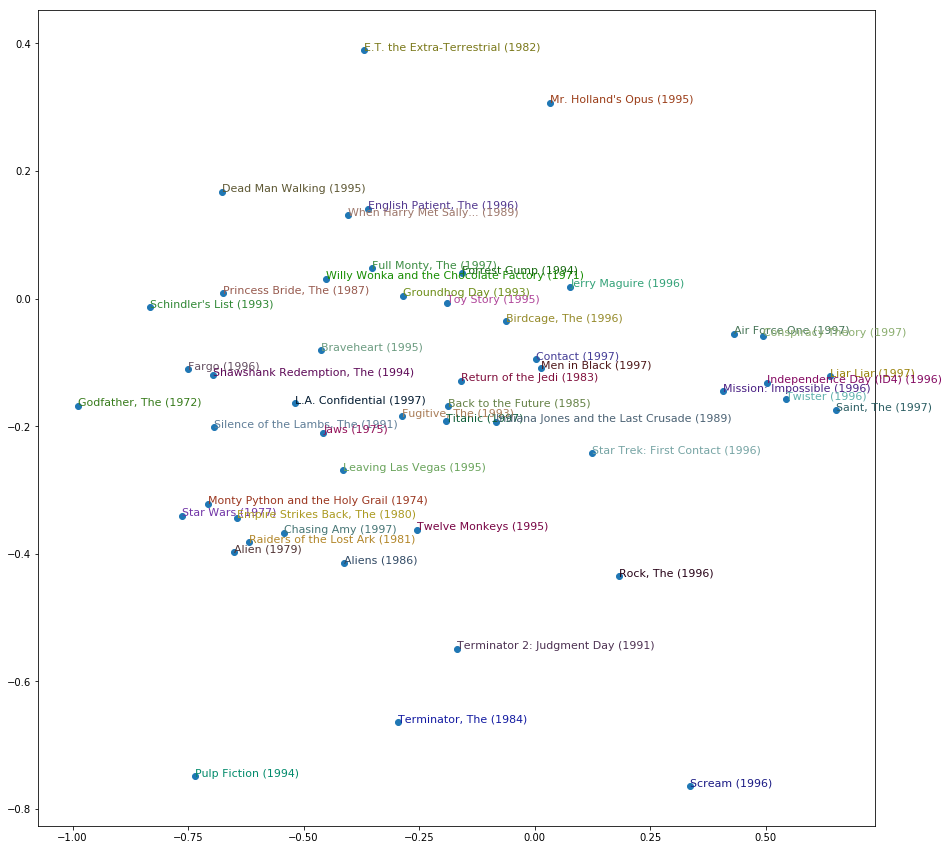

In [41]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()